# Research Notebook: Running test cases on CFMiso to probe its abilities and limits
## 20240315 mst

Here we will curate some initial surface conditions, and test the limits of the firn depth for this model.
The primary tests here will be around the Tskin. 
1. ability to simulate step changes, 
2. ability to simulate seasonal cycles, 
3. limits of firn depth in these simulations.
4. test limits and format of time resolution

These simulations will be run with a bdot = 0.

Input/output will be saved the ./CommunityFirnModel/data folder 

Start this notebook from the ./CommunityFirnModel repo directory on your computer 

## To Do, 25 March 2024

1. get json file to be more reactive to input files and file names generated in this script
2. keep experiment spin/result/json files named similar things and separate from each other.



In [3]:
import sys 

## run from notebooks folder
homePath= './CFM_main/'
inputDataPath = './data/input/'
outputDataPath = './data/output/'

sys.path.append(homePath)
#sys.path.append(inputDataPath)
#sys.path.append(outputDataPath)

### Import necessary libraries

In [4]:
# import statsmodels.api as sm
import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import netCDF4 as nc
import sys
import os
import pickle
import seaborn as sns 
import glob
from datetime import datetime, timedelta, date
import time
import json
import shutil
import xarray as xr
import copy

SPY = 365.25*24*3600

from firn_density_nospin import FirnDensityNoSpin
from siteClimate_from_RCM import getClimate #get data from RCM
from RCMpkl_to_spin import makeSpinFiles

### Set plot parameters (seaborn, matplotlib)

In [5]:
sb=True
if sb:
    sns.set()
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
#     sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid",{"xtick.top":True, "xtick.bottom":True,"ytick.left":True, "ytick.right":True})
# plt.style.use('seaborn-notebook')

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams.update({'figure.autolayout': True})
fontsz = 20

### Set CFM configuration

In [6]:
### NOTE: 22 March 2024 -- get this json file to be more reactive to the input parameters and file names generated below

### This function contains all of the CFM configuration options.
### The values here are more or less the defaults.
### You can change them here if you want to change default settings,
### but if you want to change on a run-by-run basis I recommend doing so in the cell below.

# doublegrid to True - turning on double grid routine (for faster running of things, allowing thicker firn column without much higher run times).

def makejson():
    false = False
    true = True
    c = {
    "InputFileFolder": "CFMinput",
    "InputFileNameTemp": "example_tskin.csv",
    "InputFileNamebdot": "example_smb.csv",
    "InputFileNameIso": "example_isotope.csv",
    "InputFileNamerho": "example_rhos.csv",
    "InputFileNamemelt": "example_melt.csv",
    "resultsFolder": "CFMoutput/test",
    "initfirnFile": "example_firndata.csv",
    "initprofile": false,
    "input_type": "dataframe",
    "input_type_options": ["csv","dataframe"],
    "DFresample": "1D",
    "DFfile": "MERRA2_CLIM_df_72.5_-38.75.pkl",
    "physRho": "GSFC2020",
    "physRho_options":["HLdynamic","HLSigfus","Li2004","Li2011","Helsen2008","Arthern2010S","Arthern2010T","Li2015","Goujon2003","Barnola1991","Morris2014","KuipersMunneke2015","Crocus","Ligtenberg2011"],
    "MELT": false,
    "ReehCorrectedT": false,
    "FirnAir": false,
    "AirConfigName": "AirConfig.json",
    "TWriteInt": 1,
    "TWriteStart": 1980.0,
    "int_type": "nearest",
    "int_type_options": ["nearest","linear"],
    "SeasonalTcycle": false,
    "SeasonalThemi": "north",
    "coreless": true,
    "TAmp":10.0,
    "physGrain": false,
    "calcGrainSize": false,
    "GrGrowPhysics": "Arthern",
    "GrGrowPhysics_options": ["Arthern", "Katsushima"],
    "heatDiff": true,
    "conductivity": "Calonne2019",
    "conductivity_options": ["Schwander","Yen_fixed","Yen_var","Anderson","Yen_b","Sturm","VanDusen","Schwerdtfeger","Riche","Jiawen","mix","Calonne2011","Calonne2019"],
    "variable_srho": false,
    "srho_type": "userinput",
    "srho_type_options": ["userinput","param","noise"],
    "rhos0": 350.0,
    "r2s0": 1.0e-8,
    "AutoSpinUpTime": false,
    "yearSpin": 20,
    "H": 3000,
    "HbaseSpin": 2880.0,
    "stpsPerYear": 12.0,
    "D_surf": 1.0,
    "bdot_type": "mean",
    "bdot_type_options": ["instant","mean","stress"],
    "grid_outputs": false,
    "grid_output_res": 0.25,
    "isoDiff": true,
    "iso": ["d18O","dD"],
    "isoOptions":["d18O","dD","NoDiffusion"],
    "spacewriteint": 1,
    "strain": false,
    "du_dx": 1e-5,
    "outputs": ["density", "depth", "temperature", "age", "DIP","isotopes"],
    "outputs_options": ["density", "depth", "temperature", "age", "Dcon", "bdot_mean", "climate", "compaction", "grainsize", "temp_Hx", "isotopes", "BCO", "DIPc", "DIP", "LWC","gasses", "PLWC_mem", "viscosity", "runoff",
    "refrozen"],
    "resultsFileName": "CFMresults.hdf5",
    "spinFileName": "CFMspin.hdf5",
    "doublegrid": true,
    "nodestocombine": 30,
    "multnodestocombine": 12,
    "Dnodestocombine": 30,
    "Dmultnodestocombine": 12,
    "grid1bottom": 5.0,
    "grid2bottom": 10.0,
    "spinup_climate_type": "mean",
    "spinup_climate_type_options": ["mean", "initial"],
    "manual_climate": false,
    "deepT": 255.88,
    "bdot_long": 0.49073,
    "manual_iceout": false,
    "iceout": 0.23,
    "QMorris": 110.0e3,
    "timesetup": "exact",
    "timesetup_options": ["exact","interp","retmip"],
    "liquid": "bucket",
    "liquid_options": ["percolation_bucket","bucketVV","resingledomain","prefsnowpack"],
    "merging": false,
    "merge_min": 1e-4,
    "LWCcorrect": false,
    "manualT": false,
    "no_densification": false,
    "rad_pen": false,
    "site_pressure": 1013.25,
    "output_bits": "float32",
    "spinUpdate": true,
    "spinUpdateDate": 1980.0,
    "DIPhorizon": 100.0,
    "NewSpin": true,
    "ColeouLesaffre": false,
    "IrrVal": 0.02,
    "RhoImp": 830.0,
    "DownToIce": false,
    "ThickImp": 0.1,
    "Ponding": false,
    "DirectRunoff": 0.0,
    "RunoffZuoOerlemans": false,
    "Slope": 0.1,
    "SUBLIM": True
    }

    return c

### Curate/create, save, and then upload the input data for these tests. 

In [7]:

# make temperature time series for sinusoidal tests in pandas format at minute resolution, hourly resolution, daily resolution, monthly resolution.

# add different levels of noise at the time scales (e.g. 0.1 K, 1 k, 2 k, 4 k)

cycles = 10 # how many sine cycles
resolution = 365*24*60*10 # how many datapoints to generate

length = np.pi * 2 * cycles

DTseas = 20 # size of seasonal cycle, K
Tannual = 243 # mean annual temperature, K

Tseasonal = DTseas*np.sin(np.arange(0, length, length / resolution))+Tannual
numDays = np.arange(1,len(Tseasonal)+1)




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87600 entries, 2000-01-01 00:00:00 to 2009-12-28 23:00:00
Freq: H
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Tseas0noise    87600 non-null  float64
 1   Tseas0.1noise  87600 non-null  float64
 2   Tseas1noise    87600 non-null  float64
 3   Tseas2noise    87600 non-null  float64
 4   Tseas4noise    87600 non-null  float64
 5   Tseas10noise   87600 non-null  float64
dtypes: float64(6)
memory usage: 4.7 MB


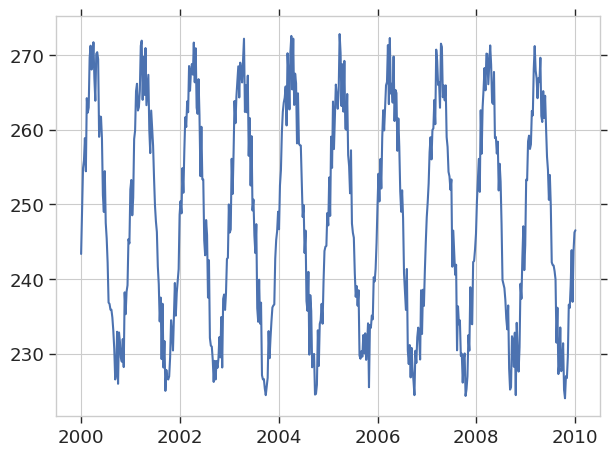

In [8]:

inputDF_min = pd.DataFrame(index = pd.DatetimeIndex(pd.period_range(start = '2000-01-01',periods=resolution,freq='min').to_timestamp()), columns = ['Tseas0noise'])
inputDF_min.Tseas0noise= Tseasonal


inputDF_hour = inputDF_min.resample('H').mean()
inputDF_day = inputDF_min.resample('D').mean()
inputDF_week = inputDF_min.resample('W').mean()
inputDF_month = inputDF_min.resample('M').mean()

# create random noise for the model tests
lenMin = len(inputDF_min.index)
lenHour = len(inputDF_hour.index)
lenDaily = len(inputDF_day.index)
lenWeek = len(inputDF_week.index)
lenMonth = len(inputDF_month.index)

listLevels = [0.1,1,2,4,10] # noise levels in K

for l in listLevels:
    inputDF_min['Tseas'+str(l)+'noise'] = inputDF_min.Tseas0noise + np.random.rand(lenMin)*l
    inputDF_hour['Tseas'+str(l)+'noise'] = inputDF_hour.Tseas0noise + np.random.rand(lenHour)*l
    inputDF_day['Tseas'+str(l)+'noise'] = inputDF_day.Tseas0noise + np.random.rand(lenDaily)*l
    inputDF_week['Tseas'+str(l)+'noise'] = inputDF_week.Tseas0noise + np.random.rand(lenWeek)*l
    inputDF_month['Tseas'+str(l)+'noise'] = inputDF_month.Tseas0noise + np.random.rand(lenMonth)*l
    

# make initial temperature profile (no spin up) for step-change tests, make step change temperature time series of 
# different magnitudes (0.1 K, 1 K, 2 K, 10 K). Use the same array of time resolution.

inputDF_min.head()

plt.figure
plt.plot(inputDF_week.index,inputDF_week.Tseas10noise)

inputDF_hour.info()


In [9]:
# fill in the rest of the DFs for evaporation, melt, total precip, snow precip, everything is zero at this point for these parameters

massParamsList = ['EVAP','SMELT','PRECTOT','PRECSNO']

for m in massParamsList:
    if (m == 'EVAP') | (m == 'SMELT'):
        inputDF_min[m]=0;
        inputDF_hour[m]=0;
        inputDF_day[m]=0;
        inputDF_week[m]=0;
        inputDF_month[m]=0;
    else:
        inputDF_min[m]=1000/365/24/60;
        inputDF_hour[m]=1000/365/24;
        inputDF_day[m]=1000/365;
        inputDF_week[m]=1000/52;
        inputDF_month[m]=1000/12;
        



In [10]:
inputDF_hour

,Tseas0noise,Tseas0.1noise,Tseas1noise,Tseas2noise,Tseas4noise,Tseas10noise,EVAP,SMELT,PRECTOT,PRECSNO
2000-01-01 00:00:00,243.007053,243.065205,243.358479,243.167817,245.365793,252.228782,0,0,0.114155,0.114155
2000-01-01 01:00:00,243.021398,243.084327,243.975541,243.865449,244.638032,252.489711,0,0,0.114155,0.114155
2000-01-01 02:00:00,243.035743,243.124969,243.490542,244.878767,246.070762,247.186958,0,0,0.114155,0.114155
2000-01-01 03:00:00,243.050089,243.054609,244.041677,244.669615,244.667688,251.993326,0,0,0.114155,0.114155
2000-01-01 04:00:00,243.064434,243.069252,243.744356,244.512017,243.596732,249.560780,0,0,0.114155,0.114155
...,...,...,...,...,...,...,...,...,...,...
2009-12-28 19:00:00,242.935327,242.985825,243.831141,243.570257,246.514099,244.654754,0,0,0.114155,0.114155
2009-12-28 20:00:00,242.949672,242.959652,243.521484,244.109453,243.906419,246.276029,0,0,0.114155,0.114155
2009-12-28 21:00:00,242.964018,243.053967,243.785338,243.172405,246.715778,248.811587,0,0,0.114155,0.114155
2009-12-28 22:00:00,242.978363,243.028698,243.040291,244.745730,244.609797,251.439765,0,0,0.114155,0.114155


### Info on how CFM runs

The CFM itself (i.e, firn_density_nospin.py) takes inputs as vectors of temperature, accumulation, etc., and decimal time. 
The following line calls a script that takes the df_daily and creates a python dictionary (called Cd, for climate dictionary)
containing the vectors that the CFM needs to run. (converts the data from df_daily into these vectors)
the function also returns some other variables that will be used to configure the CFM run. (but are not important for what you are doing, generally speaking)

so, if you want to create your own forcing data you can either create a dataframe with a datetime index, which gets turned into the dictionary in the below function call,
or you could just create a dictionary with the needed keys (['time', 'TSKIN', 'BDOT', 'd18O', 'dD']), where 'time' is decimal date
we can't use pandas exclusively with datetime indicies because the datetime64 format has limitations


#### Configure the CFM run.
the variable 'c' is a dictionary with key-value pairs
if you want to alter anything in the config file I recommend doing so here.
note that not all CFM features will work with isotopes turned on - let me know if I need to change anything for you in that regard.



In [11]:
# create dictionary of dataframes for this series of tests

listRes = ['1W','1M']   # what is the abbreviation for, probably the resample abbreviations
noiseDict = dict(zip(['0','0.1','1','2','4','10'],['Tseas0noise','Tseas0.1noise','Tseas1noise','Tseas2noise','Tseas4noise','Tseas10noise']))
dfExpDict = dict(zip(listRes,[inputDF_week, inputDF_month]))



In [12]:
# try to run with spin files, the spin files need to have the same time resolution as the no spin files. 
# save the spin files and move to another location. Then move and load the spin files for the next time you need them

# next step - tyr to create a series of init profiles, then run with no spin. 




for res in listRes:

    timeres = res # set the time resolution for the model run. '5D' is 5 days, '1M' is one month, etc

    for n in noiseDict:
        inputDF = dfExpDict[res].copy()
        inputDF = inputDF.loc[:,[noiseDict[n]]+massParamsList]
        inputDF = inputDF.rename(columns = {noiseDict[n]: 'TSKIN'})

        Cd, StpsPerYr, depth_S1, depth_S2, grid_bottom = makeSpinFiles(inputDF, timeres=timeres, Tinterp='mean', spin_date_st = 1990, spin_date_end = 2000, desired_depth=100)

        # set bottom density to be 700-800 kg/m3, rho_bottom = ?,then maybe don't set desired depth
        # or set desired_depth to a small depth. 

        # lower boundary condition is currently zero gradient, so maybe 
        # will not get longer run times for deeper snow, necessarily
        # set up sub-grid routine in json 

        # OK, this is wrong, but we will operate with it. This will have to be a different part of 'makeSpinFiles'
        Cd['d18O'] = 0.62* Cd['TSKIN'] - 15.25 #Johnsen 1989 eq. 2
        Cd['dD'] = 8.0 * Cd['d18O'] + 10 #Johnsen 1989 eq. 1

        runid=-9999

        #######
        ### Prepare config .json (which is a dictionary called c within this python script) ###
        ### edit as you wish here (the makejson function above just has defaults, you can change there as well)
        c = makejson()
        c['physRho'] = 'KuipersMunneke2015' # try with 'GSFC2020' and 'KuipersMunneke2015'
        c['runID'] = runid
        c['DFresample'] = timeres # resolution of the model run, e.g. '1d' is 1 day.
        c["doublegrid"] = False
        c['nodestocombine'] = 6 
        c['multnodestocombine'] = 12
        c['melt'] = False #you can set to false to make things run a lot faster if don't care about results
        c["stpsPerYear"] = StpsPerYr
        c["stpsPerYearSpin"] = StpsPerYr
        c["grid1bottom"] = 5
        c["grid2bottom"] = 10
        # c["grid1bottom"] = depth_S1
        # c["grid2bottom"] = depth_S2
        c["HbaseSpin"] = 3000 - grid_bottom
        c["DIPhorizon"] = np.floor(0.8*grid_bottom) # firn air content, depth integrated porosity 
        c["rhos0"] = 325.0  # e.g here you could change the surface density
        #######



        ### Specify where results should go ###
        ### alter this to reflect model-run specifics if e.g. you are doing several similar runs just varying one model setting
        reDir = '../data/output/modelTests/'
        c['resultsFolder'] = reDir
        ##########


        ## NOTE FROM 22 March 2024 --- NEXT thing to do here is to make sure the correct files are being used and saved in the appropriate places
        ## the spin file should be saved in the ./data/output/modelTests directory, then after the model has run the CFMspin.hdf5 and 
        ## CFMresultshfd5 files should be mv'ed to a more informative names (all input params described somehow, names with same name as json file) 

        
        configName = f'modelTest_{res}_res.json'
        if os.path.exists(os.path.join(c['resultsFolder'],configName)):
            CFMconfig = os.path.join(c['resultsFolder'],configName)
            shutil.move(CFMconfig, os.getcwd())
        else:
            CFMconfig = configName
        with open(CFMconfig,'w') as fp:
            fp.write(json.dumps(c,sort_keys=True, indent=4, separators=(',', ': ')))


        ### start the CFM run
        tnow = time.time()
        firn = FirnDensityNoSpin(configName,climateTS = Cd, NewSpin = True)
        firn.time_evolve()
        telap = (time.time()-tnow)/60
        print('main done, {} minutes'.format(telap))

        shutil.move(configName,reDir)

1.094406163365024
243.0001876833948
df_full (no seb):                   TSKIN  SUBLIM  SMELT  RAIN       BDOT
decdate                                                
1912.002732  243.344131       0      0   0.0  19.230769
1912.021858  244.889472       0      0   0.0  19.230769
1912.040984  247.267718       0      0   0.0  19.230769
1912.060109  249.584072       0      0   0.0  19.230769
1912.079235  251.804939       0      0   0.0  19.230769
stepsperyear: 9.652790630014684
Spin run started
physics are KuipersMunneke2015
Grid length is 882
AHL: 1.094406163365024
THL: 243.00238776273292
Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.89062099855241
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 1912.0027322404371 2010.0054794520547
main done, 0.04918789068857829 minutes
1.094406163365024
243.05035427723243
df_full (no seb):                   TSKIN

In [13]:
inputDF = dfExpDict[res].copy()
inputDF_hour

,Tseas0noise,Tseas0.1noise,Tseas1noise,Tseas2noise,Tseas4noise,Tseas10noise,EVAP,SMELT,PRECTOT,PRECSNO
2000-01-01 00:00:00,243.007053,243.065205,243.358479,243.167817,245.365793,252.228782,0,0,0.114155,0.114155
2000-01-01 01:00:00,243.021398,243.084327,243.975541,243.865449,244.638032,252.489711,0,0,0.114155,0.114155
2000-01-01 02:00:00,243.035743,243.124969,243.490542,244.878767,246.070762,247.186958,0,0,0.114155,0.114155
2000-01-01 03:00:00,243.050089,243.054609,244.041677,244.669615,244.667688,251.993326,0,0,0.114155,0.114155
2000-01-01 04:00:00,243.064434,243.069252,243.744356,244.512017,243.596732,249.560780,0,0,0.114155,0.114155
...,...,...,...,...,...,...,...,...,...,...
2009-12-28 19:00:00,242.935327,242.985825,243.831141,243.570257,246.514099,244.654754,0,0,0.114155,0.114155
2009-12-28 20:00:00,242.949672,242.959652,243.521484,244.109453,243.906419,246.276029,0,0,0.114155,0.114155
2009-12-28 21:00:00,242.964018,243.053967,243.785338,243.172405,246.715778,248.811587,0,0,0.114155,0.114155
2009-12-28 22:00:00,242.978363,243.028698,243.040291,244.745730,244.609797,251.439765,0,0,0.114155,0.114155


In [12]:
# what is in this erroneous file?
import h5py
df_out = pd.DataFrame(np.array(h5py.File("./CFMoutputs/CFMresults_iso_72.5_-36.25/CFMspin.hdf5")))
#df_out = pd.read_hdf('./CFMoutputs/CFMresults_iso_72.5_-36.25/CFMspin.hdf5')

df_out

,0
0,IsoSpin_d18O
1,IsoSpin_dD
2,ageSpin
3,bdot_meanSpin
4,densitySpin
5,depthSpin
6,iso_sig2_d18O
7,iso_sig2_dD
8,tempSpin


In [13]:
fns = ['test_run_1']
rd = {} #results dictionary. I use nested dictionaries to load results from several runs in an organized fashion, e.g. 
# Ideally you do this with the naming of results directory above and loop through what you are changing

for rt in fns:
    print(rt)
    rd[rt] = {}
    ff = f'CFMoutputs/CFMresults_iso_72.5_-36.25/CFMresults.hdf5'
    with h5.File(ff,'r') as fn:# Open the CFM results file
        vars_list = list(fn.keys()) # Make a list of the variables stored in the file
        # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
        # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want.
        rd[rt]['model_time'] = fn['density'][1:,0] # the first column of the density data is the model time step.
        rd[rt]['depth'] = fn['depth'][1:,1:] # Put the depth data into a numpy array
        rd[rt]['density'] = fn['density'][1:,1:] # Put the density data into an array
        rd[rt]['temperature'] = fn['temperature'][1:,1:]
        rd[rt]['sig2_d18O'] = fn['iso_sig2_d18O'][1:,1:]
        rd[rt]['sig2_dD'] = fn['iso_sig2_dD'][1:,1:]
        rd[rt]['isotopes_d18O'] = fn['isotopes_d18O'][1:,1:]
        rd[rt]['isotopes_dD'] = fn['isotopes_dD'][1:,1:]
        # rd[rt]['DIP'] = fn['DIP'][1:,1:]


test_run_1


Text(0, 0.5, 'Depth (m)')

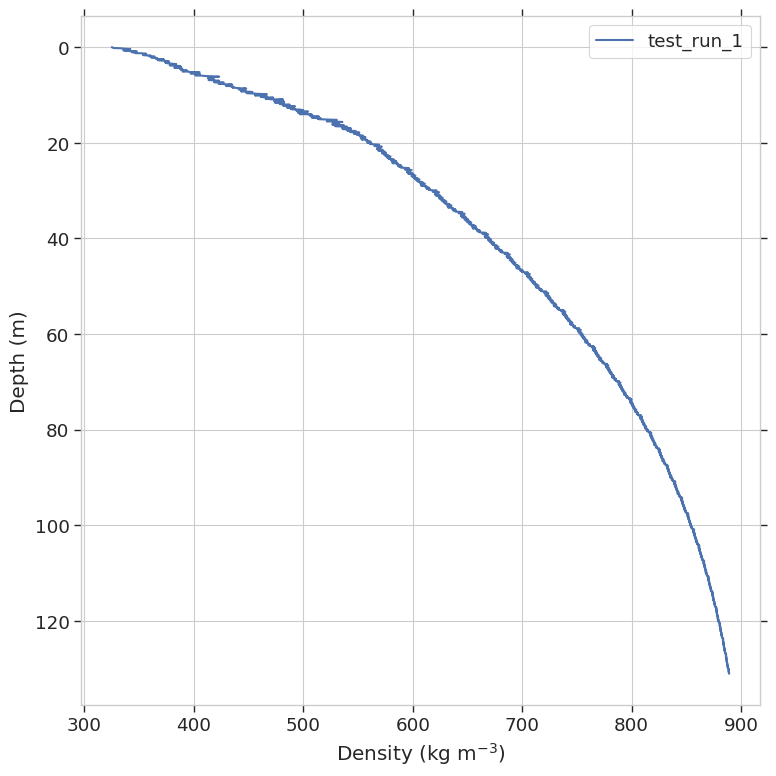

In [14]:
### Plot depth/density
# this is the density profile at the last time

f1,a1=plt.subplots(figsize=(8,8))
for rt in fns:
    a1.plot(rd[rt]['density'][-1,:],rd[rt]['depth'][-1,:],label=rt)
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('Density (kg m$^{-3}$)')
a1.set_ylabel('Depth (m)')



Text(0, 0.5, 'Depth (m)')

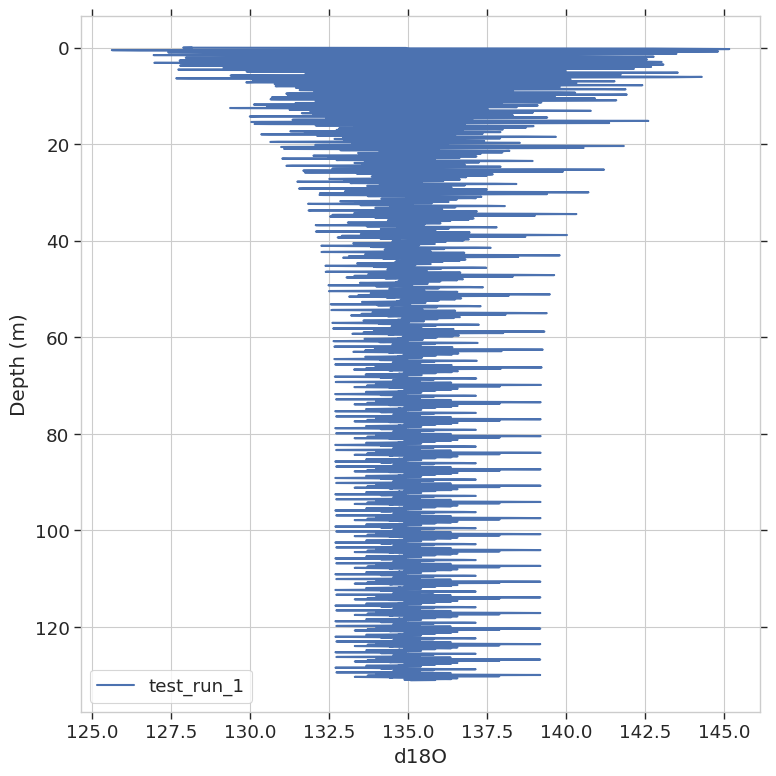

In [15]:
### Plot depth/density
f1,a1=plt.subplots(figsize=(8,8))
for rt in fns:
    a1.plot(rd[rt]['isotopes_d18O'][-1,:],rd[rt]['depth'][-1,:],label=rt)
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('d18O')
a1.set_ylabel('Depth (m)')

Text(0, 0.5, 'Depth (m)')

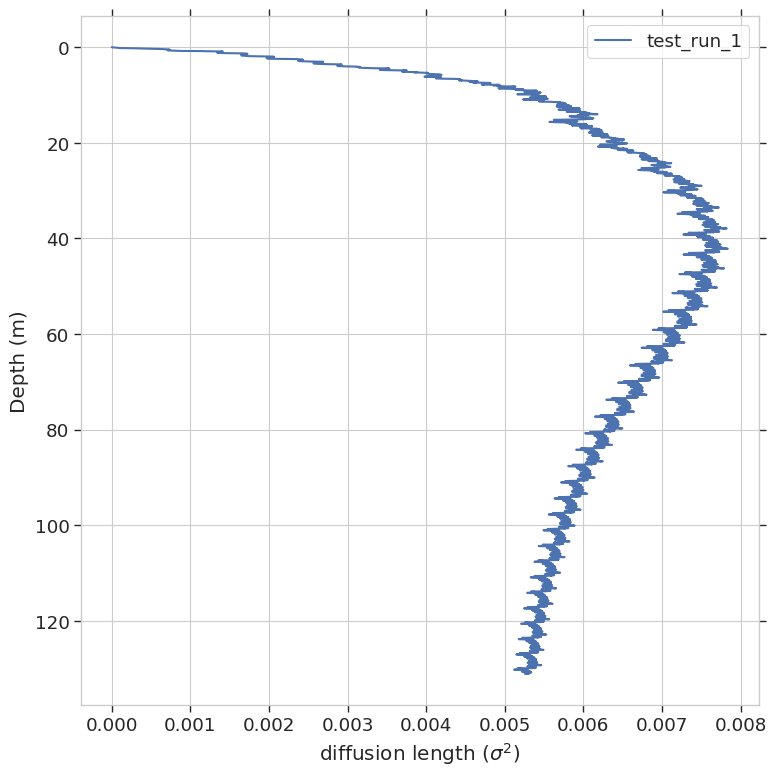

In [16]:
### Plot depth/density
f1,a1=plt.subplots(figsize=(8,8))
for rt in fns:
    a1.plot(rd[rt]['sig2_d18O'][-1,:],rd[rt]['depth'][-1,:],label=rt)
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('diffusion length ($\sigma^{2}$)')
a1.set_ylabel('Depth (m)')